# training check

In [1]:
import numpy as np
import torch
from datasets.dataset_multitask_1d import motask_generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18

plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

In [3]:
import time 
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [24]:
# from models.test_baseline import Convcnp,compute_loss_baseline
# from models.test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# from models.test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  
# from models.test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  


# # nchannels = 3
# # in_channels = nchannels

# num_nchannels = 3
# lr = 0.001
# weight_decay=1e-4
# nsamples_latent=10
# nsamples_gp=10

# #def get_model(modelname='gp'):        
# def get_model(modelname='gp',cnntype='deep'):        
    
#     if modelname == 'base':
#         model = Convcnp(in_dims=1,out_dims=1,num_channels=num_nchannels,cnntype=cnntype).cuda()
#         opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
#         lossfun = compute_loss_baseline

#     if modelname == 'baselatent':
#         model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_latent,cnntype=cnntype).cuda()
#         opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
#         lossfun = compute_loss_baselinelatent
        
#     #if modelname == 'gp_ind':
#     #if modelname == 'gpind':        
#     if modelname in ['gpind','gpindrbf'] :                
#         model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
#         opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
#         lossfun = compute_loss_gp
        
        
#     #if modelname == 'gp_dep':
#     if modelname == 'gpdep':        
#         model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=num_nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
#         opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
#         lossfun = compute_loss_gp
        
      
#     return model,opt,lossfun



In [91]:
# # from test_baseline import Convcnp,compute_loss_baseline
# # from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# # #from test_correlatenp import  CGP_Convnp,compute_loss_gp        
# # from test_mocorrelatenp import  CGP_Convnp,compute_loss_gp        
# import sys
# sys.path.append('./../')

from models.test_baseline import Convcnp,compute_loss_baseline
from models.test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from models.test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  
from models.test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
from models.test_cnp import RegressionANP, RegressionCNP
from torch.distributions.normal import Normal

nchannels= 3
nsamples_latent=10
nsamples_gp=10

lr = 0.001
weight_decay=1e-4
def get_model(modelname='gp',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=nchannels,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=nchannels,num_postsamples=nsamples_latent,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    #if modelname == 'gp_ind':
    #if modelname == 'gpind':        
    if modelname in ['gpind','gpindrbf']:        
        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    #if modelname == 'gp_dep':
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=nchannels,num_postsamples=nsamples_gp,cnntype=cnntype).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
#     #----------------------
#     #needed to check run
#     #----------------------
#     if modelname == 'anp':
#         num_samples = 1        
#         model = RegressionANP(input_dim=num_nchannels,
#                               latent_dim=128,
#                               num_channels=num_nchannels).cuda()        
#         opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)        
#         lossfun = compute_loss_baseline
        
        
#     if modelname == 'cnp':
#         num_samples = 1                
#         model = RegressionCNP(input_dim=num_nchannels,
#                               latent_dim=128,
#                               num_channels=num_nchannels).cuda()
#         opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)        
#         lossfun = compute_loss_baseline
        
      
    return model,opt,lossfun





proposed_model_list = ['gpind','gpindrbf','gpdep']
def validate_epochs_pair(batch_dataset_pair,model,lossfun):
    # large is better 
    
    model.eval()
    
    likelihoods = []
    likelihoods2 = []    
    ntask = len(batch_dataset_pair)
    for dataset_pair in batch_dataset_pair:
        
#        try:        
        context_x,context_y,target_x,target_y,full_x,full_y = dataset_pair        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)


        outs = model(context_x.cuda(),context_y.cuda(),target_x.cuda())                        
        obj = -lossfun( outs.pymu, outs.pystd, target_y.cuda(), intrain=False, reduce=False)        
            
        likelihoods += list(obj.cpu().data.numpy())        

        
    
    
    likelihoods=np.array(likelihoods)                
    num_nanlikelihoods = np.count_nonzero(~np.isnan(likelihoods))
    avg_ll,std_ll = np.nanmean(likelihoods).round(2), (np.nanstd(likelihoods)/np.sqrt(num_nanlikelihoods+1e-8)).round(2)    
    
    num_nanlikelihoods2 = np.count_nonzero(~np.isnan(likelihoods2))    
    avg_ll2,std_ll2 = np.nanmean(likelihoods2).round(2), (np.nanstd(likelihoods2)/np.sqrt(num_nanlikelihoods2+1e-8)).round(2)    
    
    return avg_ll,std_ll,avg_ll2,std_ll2      

    


    

## loads dataset and checks

In [92]:
#pstd_xt
import matplotlib.pyplot as plt

figsiz_=(20,2)
color_list = ['r','b','g']
#predicted_model_list = ['gpind','gpdep','baselatent']
predicted_model_list = ['gpind','gpindrbf','gpdep','baselatent']

In [93]:
#len(train_set)
#train_set[0][0].shape,train_set[0][2].shape,train_set[-1][0].shape,train_set[-1][2].shape,train_set[32][0].shape,train_set[32][2].shape

In [94]:
#

## Take models and load params

# check the number of data points for training

## load dataset

In [95]:
tasktype = 'sin3varying'
testtype = 'extra'
dep = True
datav=11

In [96]:
import glob
#saved_dataset_list = glob.glob('./syndata_{}_v{}_varyingnct/dep{}*.db'.format(tasktype,datav,dep))
saved_dataset_list = glob.glob('./syndata_{}_varyingnct/dep{}*.db'.format(tasktype,dep))

saved_dataset_list.sort()
saved_dataset_list

['./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10.db']

# get_params

In [97]:

# tasktype = 'sin3'
# testtype = 'extra'
# dep = True
# datav = 11

tasktype = 'sin3varying'
testtype = 'extra'
dep = True
datav=11
bestparam_path = './bestparams/bestparam_{}/'.format(tasktype)
bestparam_path


'./bestparams/bestparam_sin3varying/'

In [98]:
#for ith_saved_modelparam_path_list
import glob

#def filter_savefilename(tasktype='mosm', depoption=True,datav=['datav4'],runv=['runv25']):
def filter_savefilename(bestparam_path='./', depoption=True,datav=['datav4'],runv=['runv25']):
    
    #saved_modelparam_path_list = glob.glob('./param_{}/*.pth'.format(tasktype))
    #saved_modelparam_path_list = glob.glob('./bestparam_{}/*.pth'.format(tasktype))
    #print(bestparam_path)
    saved_modelparam_path_list = glob.glob(bestparam_path+'*.pth')
    
    saved_modelparam_path_list.sort()
    #print(saved_modelparam_path_list)
    
    outs = []
    for ith in saved_modelparam_path_list:
        #print(ith)
        #data0 = ith.split('/')[-2].split('_')[-1] 
        spec = ith.split('/')[-1].split('_')
        #print(spec)
        if (spec[7] in datav and datav is not None) and (spec[9] in runv and runv is not None):                                                         
            if spec[0] == 'dep'+str(depoption):                            
                outs.append(ith)
    return outs

In [54]:
saved_modelparam_path_list = filter_savefilename(bestparam_path,depoption=dep,datav=['datav11'],runv=['runv60','runv61']) #shallow network
saved_modelparam_path_list

['./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth']

In [55]:
from collections import OrderedDict
from torch.distributions.normal import Normal

import torch.nn.functional as F
import time 

ncontext_list = []
result_dict = OrderedDict()
for ith_datapath in saved_dataset_list:
    #print(ith_datapath)
    loaded = torch.load(ith_datapath)
    testset_inrange = loaded['train_set']
    testset_outrange = loaded['valid_set']    
    ncontext,ntarget = loaded['ncontext'],loaded['ntarget']
    ncontext_list.append(ncontext)
        #print(ncontext,ntarget )

    for saved_modelparam_path in saved_modelparam_path_list:   
        tic = time.time()
        #print(saved_modelparam_path.split('/'))
        #_,param_saved,param_detail = saved_modelparam_path.split('/')
        _,_,param_saved,param_detail = saved_modelparam_path.split('/')
        
        #_,_,param_saved,param_detail = saved_modelparam_path.split('/')
        
        tasktype = param_saved.split('_')[1]
        deptype = param_detail.split('_')[0]
        modelname = param_detail.split('_')[2]
        cnntype = param_detail.split('_')[4]

        model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
        #print(param_detail )
        #print('F.softmax(model.gpsampler.loglogits,dim=-1)')
        #print(F.softmax(model.gpsampler.loglogits,dim=-1))
        
#        try:
        saved_dict = torch.load(saved_modelparam_path)
        model.load_state_dict(saved_dict['state_dict'])        
        #print('F.softmax(model.gpsampler.loglogits,dim=-1)')
        #print(F.softmax(model.gpsampler.loglogits,dim=-1))

        #testin_loss_mean,testin_loss_std  = validate_epochs_pair(testset_inrange,model,lossfun )
        #testout_loss_mean,testout_loss_std  = validate_epochs_pair( testset_outrange,model,lossfun )  
        testin_loss_mean,testin_loss_std,testin_loss_mean2,testin_loss_std2  = validate_epochs_pair(testset_inrange,model,lossfun )
        testout_loss_mean,testout_loss_std,testout_loss_mean2,testout_loss_std2  = validate_epochs_pair( testset_outrange,model,lossfun )  



        #i_dict_name = modelname + '_' + param_detail.split('_')[7] + '_' + param_detail.split('_')[9]            
        #i_dict_name = param_detail
        #i_dict_name = saved_modelparam_path
        i_dict_name = modelname+cnntype
        
        #print(i_dict_name)
        if i_dict_name  not in result_dict.keys():
            result_dict[i_dict_name ] = {'testin':[],'testout':[]}
            result_dict[i_dict_name ]['testin'].append((testin_loss_mean,testin_loss_std))
            result_dict[i_dict_name ]['testout'].append((testout_loss_mean,testout_loss_std))        
        else:
            result_dict[i_dict_name ]['testin'].append((testin_loss_mean,testin_loss_std))
            result_dict[i_dict_name ]['testout'].append((testout_loss_mean,testout_loss_std))


#             if hasattr(model.gpsampler,'neural_loglogits'):
#                 i_dict_name2 = i_dict_name.upper()
#                 if i_dict_name2  not in result_dict.keys():            
#                     #print(testin_loss_mean,testin_loss_std,testin_loss_mean2,testin_loss_std2 )
#                     result_dict[i_dict_name2 ] = {'testin':[],'testout':[]}            
#                     result_dict[i_dict_name2 ]['testin'].append((testin_loss_mean2,testin_loss_std2))
#                     result_dict[i_dict_name2 ]['testout'].append((testout_loss_mean2,testout_loss_std2))
#                 else:
#                     result_dict[i_dict_name2 ]['testin'].append((testin_loss_mean2,testin_loss_std2))
#                     result_dict[i_dict_name2 ]['testout'].append((testout_loss_mean2,testout_loss_std2))

        print('[ncontext: {}, ntarget: {}] \t {} done \t taken {:.2f}'.format(ncontext,ntarget,saved_modelparam_path, time.time()-tic))       
#         except:
#             pass
    print('')
        
        
for i_key in  result_dict:
    result_dict[i_key]['testin'] = np.array(result_dict[i_key]['testin']).round(2)
    result_dict[i_key]['testout'] = np.array(result_dict[i_key]['testout']).round(2)

/home/yohan/Myenv/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: Mean of empty slice
/home/yohan/Myenv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[ncontext: 10, ntarget: 50] 	 ./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth done 	 taken 0.45
[ncontext: 10, ntarget: 50] 	 ./bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth done 	 taken 1.13
spikeslab version 7 with tempering 0.1
[ncontext: 10, ntarget: 50] 	 ./bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth done 	 taken 1.52
[ncontext: 10, ntarget: 50] 	 ./bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth done 	 taken 1.26
[ncontext: 10, ntarget: 50] 	 ./bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth done 	 taken 1.26



In [ ]:
#result_dict

In [56]:
def filter_result_dict(result_dict):
    f_result_dict = OrderedDict()
    for i_key in result_dict:
        #i_model = i_key.split('_')[2]
        #i_model = i_key.split('/')[-1].split('_')[2]
        i_model = i_key
        avg_val = result_dict[i_key]['testin'].mean(axis=0)[0]+result_dict[i_key]['testout'].mean(axis=0)[0]
        #groupby modelname
        if i_model not in f_result_dict.keys():
            f_result_dict[i_model] = {}
            f_result_dict[i_model].update({i_key:avg_val.round(2)})
        else:
            f_result_dict[i_model].update({i_key:avg_val.round(2)})

    #f_result_dict['gpind']

    o_result_dict = OrderedDict()
    for j_key in f_result_dict:
        #print('f_result_dict[j_key]')
        #print(f_result_dict[j_key])
        #sorted_dict = sorted(f_result_dict[j_key].items())
        sorted_dict = sorted(f_result_dict[j_key].items(), key=lambda item: item[1])
        f_result_dict[j_key] = dict(sorted_dict)
        #print(sorted_dict)
        #print('')
        
        target_key = sorted_dict[-1][0] #key having the latgest mnll, that is correct
        #target_key = sorted_dict[0][0] #key having the smallest mnll
        
        o_result_dict[target_key] = result_dict[target_key]

    #o_result_dict
    return f_result_dict,o_result_dict

In [57]:

#dict(sorted(f_result_dict['gpind'].items(), key=lambda item: item[1]))
#result_dict.keys()

In [58]:
f_result_dict,o_result_dict = filter_result_dict(result_dict)

In [59]:
f_result_dict,o_result_dict

(OrderedDict([('basedeep', {'basedeep': -1.24}),
              ('baselatentdeep', {'baselatentdeep': -2.68}),
              ('gpdepdeep', {'gpdepdeep': 0.04}),
              ('gpinddeep', {'gpinddeep': -0.97}),
              ('gpindrbfdeep', {'gpindrbfdeep': -1.22})]),
 OrderedDict([('basedeep',
               {'testin': array([[-0.62,  0.01]]),
                'testout': array([[-0.62,  0.01]])}),
              ('baselatentdeep',
               {'testin': array([[-1.34,  0.01]]),
                'testout': array([[-1.34,  0.01]])}),
              ('gpdepdeep',
               {'testin': array([[0.01, 0.01]]),
                'testout': array([[0.03, 0.01]])}),
              ('gpinddeep',
               {'testin': array([[-0.47,  0.01]]),
                'testout': array([[-0.5 ,  0.01]])}),
              ('gpindrbfdeep',
               {'testin': array([[-0.6 ,  0.01]]),
                'testout': array([[-0.62,  0.01]])})]))

In [60]:
#result_dict[ith_key][eval_task]

#result_dict_fig = o_result_dict
result_dict_fig = result_dict

In [61]:
result_dict_fig 

OrderedDict([('basedeep',
              {'testin': array([[-0.62,  0.01]]),
               'testout': array([[-0.62,  0.01]])}),
             ('baselatentdeep',
              {'testin': array([[-1.34,  0.01]]),
               'testout': array([[-1.34,  0.01]])}),
             ('gpdepdeep',
              {'testin': array([[0.01, 0.01]]),
               'testout': array([[0.03, 0.01]])}),
             ('gpinddeep',
              {'testin': array([[-0.47,  0.01]]),
               'testout': array([[-0.5 ,  0.01]])}),
             ('gpindrbfdeep',
              {'testin': array([[-0.6 ,  0.01]]),
               'testout': array([[-0.62,  0.01]])})])

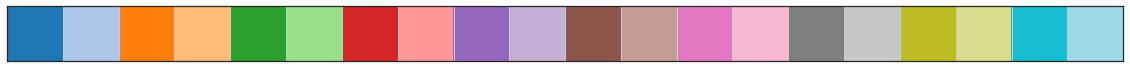

In [62]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(5+1, l=.6, s=1.0))
#current_palette = sns.color_palette('tab20')
#current_palette = sns.color_palette('Set1')
#current_palette = sns.color_palette('bright')
#current_palette = sns.color_palette('tab10')
current_palette = sns.color_palette('tab20')

sns.palplot(current_palette)
current_palette = np.asarray(current_palette)


In [63]:
list(result_dict_fig.keys())

['basedeep', 'baselatentdeep', 'gpdepdeep', 'gpinddeep', 'gpindrbfdeep']

In [64]:
#['base_runv14', 'gpind_runv14', 'gpdep_runv14']
# tab10
# legend_dict = {'basedeep':'ConvCNP', 'baselatentdeep':'ConvLNP', 'gpinddeep':'GPConvCNP', 'gpdepdeep':'Proposed'}
# color_dict = {'basedeep':current_palette[3], 'baselatentdeep':current_palette[1], 'gpinddeep':current_palette[0], 'gpdepdeep':current_palette[2]}

legend_dict = {'basedeep':'ConvCNP', 'baselatentdeep':'ConvLNP', 'gpinddeep':'GPConvCNP-SM' , 'gpindrbfdeep':'GPConvCNP-RBF', 'gpdepdeep':'Proposed'}
color_dict = {'basedeep':current_palette[6], 'baselatentdeep':current_palette[2],
              'gpinddeep':current_palette[0],'gpindrbfdeep':current_palette[-2], 
              'gpdepdeep':current_palette[4]}



# fig togethers

In [103]:

tasktype = 'sin3varying'
#tasktype = 'mosmvarying'

testtype = 'extra'
dep = True
#dep = False

#datav = 9
#datav = 10
datav = 11



In [104]:
saved_modelparam_path_list = filter_savefilename(bestparam_path,depoption=dep,datav=['datav11'],runv=['runv60','runv61']) #shallow network
saved_modelparam_path_list

['./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth']

# load dataset

In [105]:

#pstd_xt
import matplotlib.pyplot as plt

#figsiz_=(15,1.8*3)
figsiz_=(6*3,2.25)
color_list = ['r','b','g'] 
predicted_model_list = ['gpind','gpdep','baselatent']

delta = 0.2
y_ = 4
xlim_=[0-delta,3+delta]
ylim_=[-y_-delta,y_+delta]
alpha_=0.2


In [106]:
datatype = tasktype
datatype

'sin3varying'

In [107]:
#modelname
saved_modelparam_path_list

['./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth']

In [108]:
fontsiz_ = 13

In [109]:
ncontext='10'

In [110]:
nchannels


3

savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10
./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_base_ncontext10_idx4


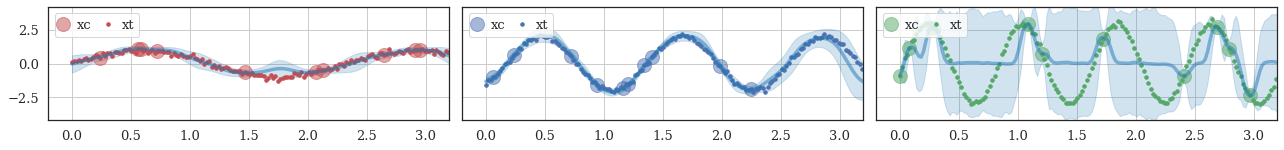





./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_base_ncontext10_idx16


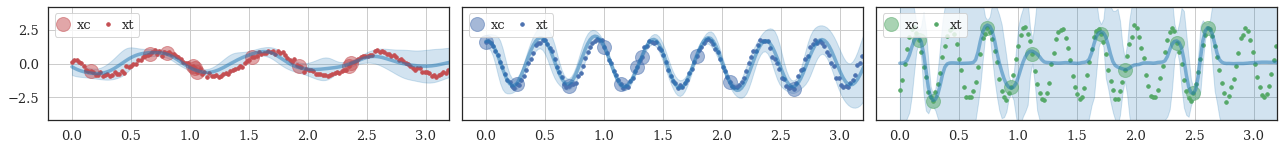





savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10
./bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_baselatent_ncontext10_idx4


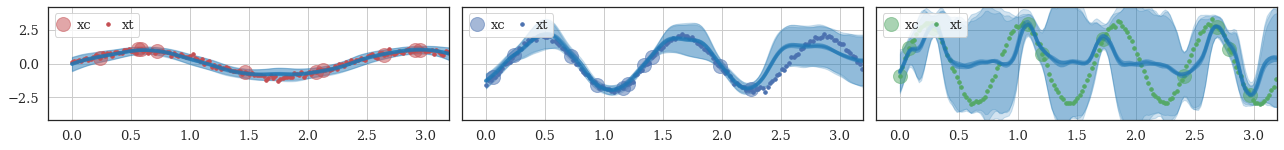





./bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_baselatent_ncontext10_idx16


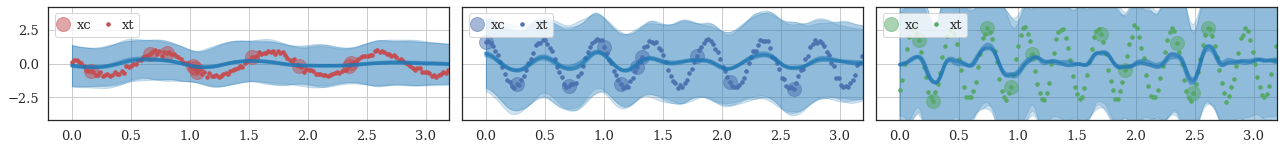





spikeslab version 7 with tempering 0.1
savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10
tensor([[[9.6063e-01, 3.1458e-02, 1.4360e-08, 3.4920e-11, 7.9073e-03],
         [2.2065e-07, 1.0000e+00, 5.7682e-09, 1.7344e-14, 3.6174e-13],
         [9.2073e-08, 1.2987e-01, 8.7013e-01, 2.0212e-14, 6.2714e-07]]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
./bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_gpdep_ncontext10_idx4


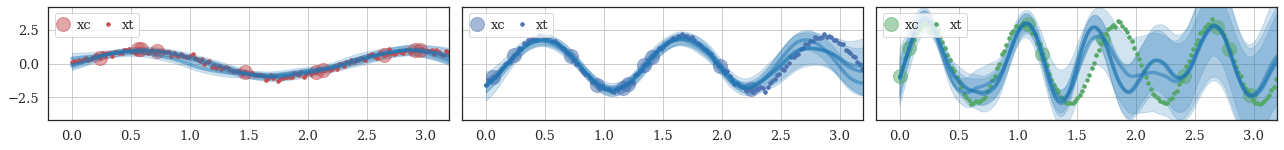





tensor([[[2.2450e-01, 7.6386e-01, 1.5450e-06, 4.6535e-10, 1.1635e-02],
         [3.7473e-19, 2.3288e-12, 1.0000e+00, 5.3990e-13, 1.4929e-15],
         [1.7716e-24, 5.7278e-19, 1.1005e-09, 1.0000e+00, 6.1243e-12]]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
./bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_gpdep_ncontext10_idx16


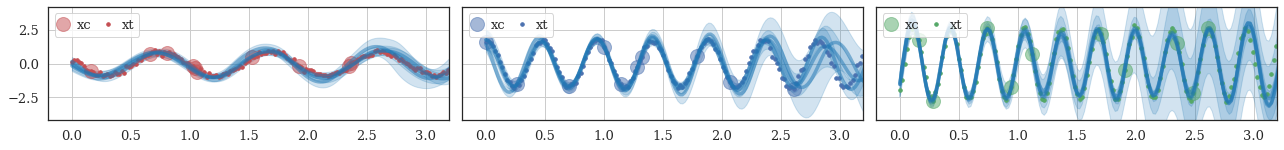





savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10
./bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_gpind_ncontext10_idx4


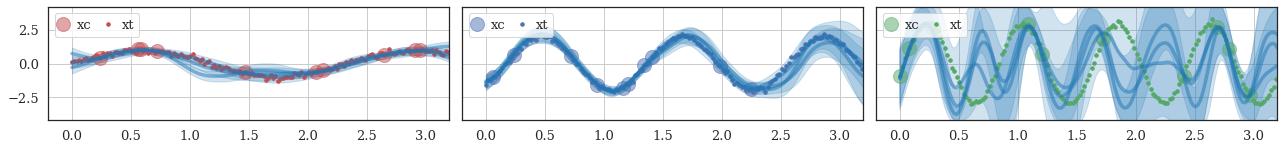





./bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_gpind_ncontext10_idx16


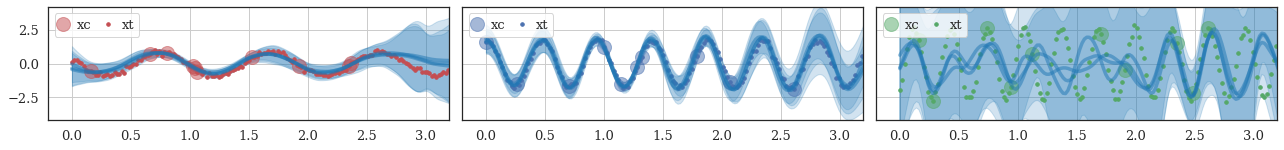





savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10
./bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_gpindrbf_ncontext10_idx4


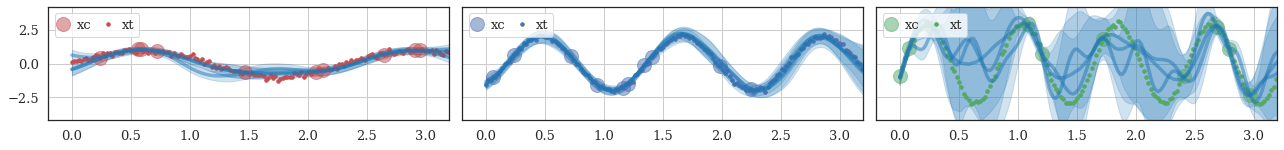





./bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])
savefigname: ./sin3varying_datav11_deptrue_gpindrbf_ncontext10_idx16


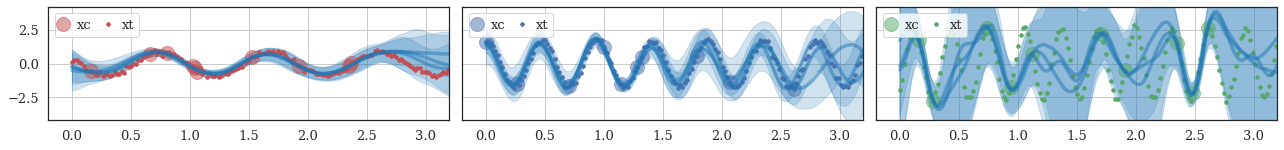

In [111]:

chosen_idx=10
idx = 1

for saved_modelparam_path in saved_modelparam_path_list:
    #_,_,param_saved,param_detail = saved_modelparam_path.split('/')
    #_,param_saved,param_detail = saved_modelparam_path.split('/')
    _,_,param_saved,param_detail = saved_modelparam_path.split('/')

    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]    
    dep=True if deptype == 'depTrue' else False

    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    #datav = int(param_detail.split('_')[7][-5])
    #datav=4

    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(saved_modelparam_path)
    model.load_state_dict(saved_dict['state_dict'])
    model.num_samples = 3



    dep=True if deptype == 'depTrue' else False
    #save_path_set = './regression_task/syndata_{}_v{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype,datav, dep, testtype, ncontext)
    #save_path_set = './syndata_{}_v{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype,datav, dep, testtype, ncontext)
    save_path_set = './syndata_{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype, dep, testtype, ncontext)

    print('savepatt_set: {}'.format(save_path_set))
    loaded = torch.load(save_path_set + '.db')
    train_set = loaded['train_set']
    #train_set = loaded['valid_set']

    #-----------------------------------
    #predict
    #-----------------------------------
    #for chosen_idx in [0,4,8,12,16]:    
    
    
    model.train()
    for chosen_idx in [4,16]:    
        
    #for chosen_idx in [0,4,8]:            
    #for chosen_idx in [0,12]:    
    #for chosen_idx in [0,8]:    


        xc,yc,xt,yt,xf,yf = train_set[chosen_idx]
        xc_ = xc[idx][...,None,:].unsqueeze(dim=0)
        yc_ = yc[idx].unsqueeze(dim=0)
        #yc_ = 0.*yc[idx].unsqueeze(dim=0)        # counter example, memorization does nor happen in our model
        xt_ = xt[idx][...,None,:].unsqueeze(dim=0)
        yt_ = yt[idx].unsqueeze(dim=0)
        xf_ = xf[idx][...,None,:].unsqueeze(dim=0)
        yf_ = yf[idx].unsqueeze(dim=0)

        xstar,ystar = xf_,yf_     
        #xstar,ystar = xt_,yt_     


        model.eval()
        if model.modelname in proposed_model_list:


            outs = model(xc_.cuda(),yc_.cuda(),xstar.cuda())       
        else:
            outs = model(xc_[:,:,0,:].cuda(),yc_.cuda(),xstar[:,:,0,:].cuda())       
        pmu_xt,pstd_xt = outs.pymu,outs.pystd

        if (hasattr(model,'gpsampler'))  and (hasattr(model.gpsampler,'neural_loglogits')):
            print(F.softmax(model.gpsampler.neural_loglogits,dim=-1))




        fig, axs = plt.subplots(1, 3,figsize=figsiz_ , sharey=True)            
        plt.subplots_adjust( wspace=0.0, hspace=0.0)


        color_list = ['r','b','g']
        if model.modelname in predicted_model_list:
            #fig=plt.figure(figsize=figsiz_)
            for i in range(nchannels):
                #plt.subplot(1,3,i+1)
                axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=14,label='xc',alpha=0.5)    
                #plt.plot(xt_[0,:,0,i].cpu().data.numpy(),yt_[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=7,label = 'target')                
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),ystar[0,:,i].cpu().data.numpy(),color_list[i]+'.',markersize=7,label = 'xt')                

                for j in range(model.num_samples):

                    #plt.plot(xstar[0,:,0,i].cpu().data.numpy(),pmu_xt[j,0,:,i].cpu().data.numpy(),color_list[i]+'-',markersize=5)
                    #plt.plot(xstar[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),color_list[i]+'--')
                    #plt.plot(xstar[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),color_list[i]+'--')


                    axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),pmu_xt[j,0,:,i].cpu().data.numpy(),color='tab:blue',linewidth=3.5,alpha=2.5*alpha_) #,label = 'Model'
                    axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                     (pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                     (pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                     color='tab:blue', alpha=alpha_)                                    

                    axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
                    axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
                    axs[i].set_xlim(xlim_)
                    axs[i].set_ylim(ylim_)
                    axs[i].legend(loc='upper left',fontsize=fontsiz_,ncol=4,labelspacing=1.0,handlelength=0.5,columnspacing=1.0)

            #plt.show()

    #print('\n'*3)

        else:
#             fig=plt.figure(figsize=figsiz_)
#             plt.subplots_adjust( wspace=0.05, hspace=0.0)
            #_, axs = plt.subplots(1, 3,figsize=figsiz_ , sharey=True)            
            #plt.subplots_adjust( wspace=0.05, hspace=0.0)

            for i in range(nchannels):
                #plt.subplot(1,3,i+1)
                axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=14,label='xc',alpha=0.5)    
                #plt.plot(xt_[0,:,0,i].cpu().data.numpy(),yt_[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=7,label = 'target')                
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),ystar[0,:,i].cpu().data.numpy(),color_list[i]+'.',markersize=7,label = 'xt')                


                #plt.plot(xstar[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color_list[i]+'-',markersize=5)
                #plt.plot(xstar[0,:,0,i].cpu().data.numpy(),(pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'--')
                #plt.plot(xstar[0,:,0,i].cpu().data.numpy(),(pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),color_list[i]+'--')

                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),pmu_xt[0,:,i].cpu().data.numpy(),color='tab:blue',linewidth=3.5,alpha=2.5*alpha_)   #,label = 'Model'             
                axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                 (pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),
                                 (pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),
                                 color='tab:blue', alpha=alpha_)                


                axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
                axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
                axs[i].set_xlim(xlim_)
                axs[i].set_ylim(ylim_)
                axs[i].legend(loc='upper left',fontsize=fontsiz_,ncol=4,labelspacing=1.0,handlelength=0.5,columnspacing=1.0)

            #plt.show()

        print(saved_modelparam_path)
        print('xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape')
        print(xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape)

        fig.tight_layout()    
        #savefigname = './' + datatype  + '_datav{}_dep{}'.format(datav,str(dep).lower())+ '_comparison_varyingcontext' + '_outrange' 
        #savefigname = './' + datatype  + '_datav{}_dep{}_ncontext{}_idx{}'.format(datav,str(dep).lower(),ncontext,chosen_idx) 
        savefigname = './' + datatype  + '_datav{}_dep{}_{}_ncontext{}_idx{}'.format(datav,str(dep).lower(), modelname ,ncontext,chosen_idx) 
        print('savefigname: {}'.format(savefigname))
        
        #if modelname in ['gpdep']:
        #    plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
        plt.show()

        print('\n'*3)


In [112]:
tmp_numsamples = 3

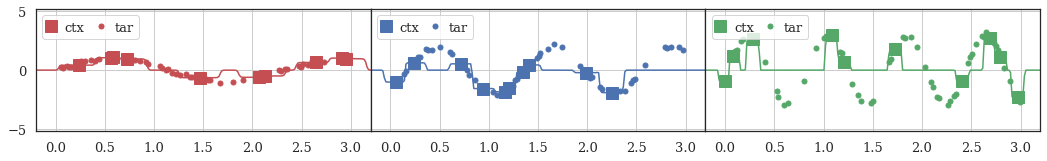

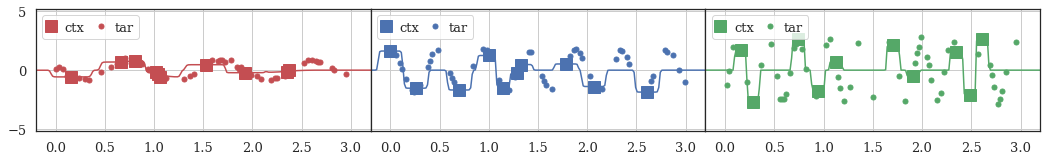

./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






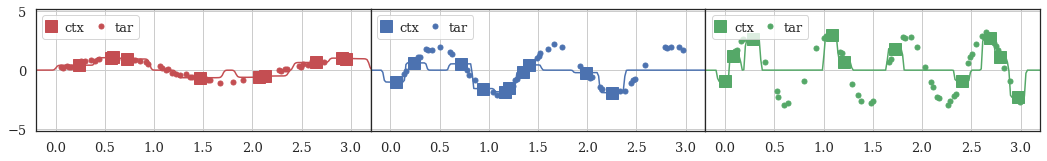

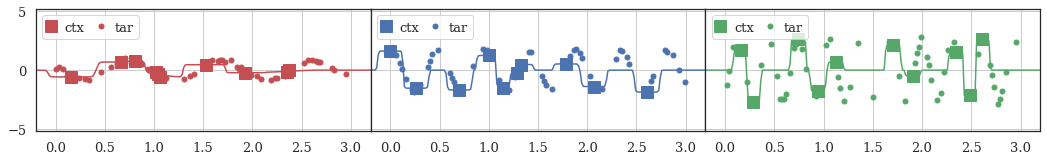

./bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])




spikeslab version 7 with tempering 0.1


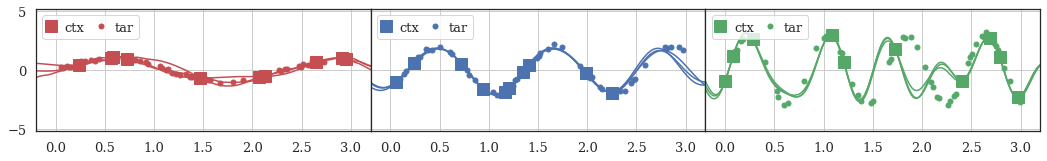

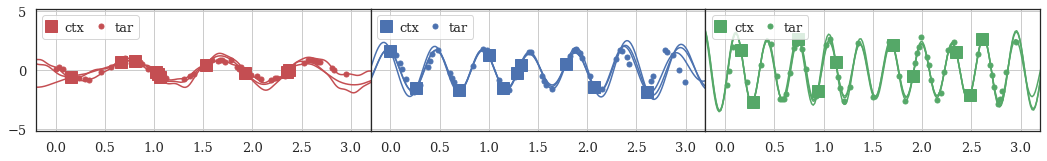

./bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






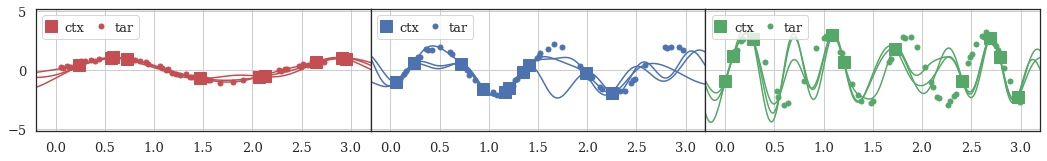

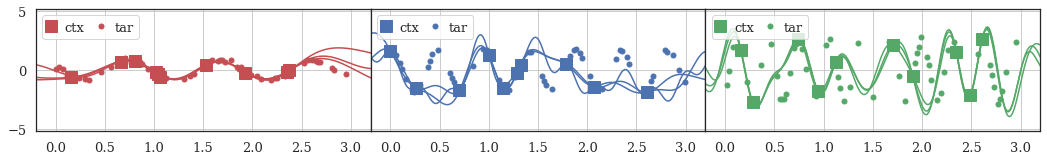

./bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






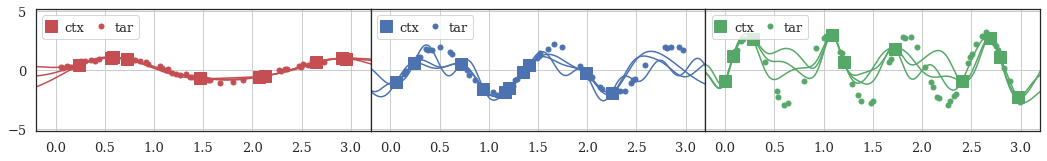

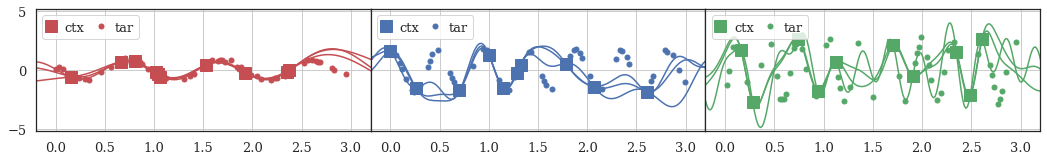

./bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






In [115]:
delta = 0.2
y_ = 5
xlim_=[0-delta,3+delta]
ylim_=[-y_-delta,y_+delta]

chosen_idx=32
idx = 1

for saved_modelparam_path in saved_modelparam_path_list:

    _,_,param_saved,param_detail = saved_modelparam_path.split('/')
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]    
    dep=True if deptype == 'depTrue' else False

    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    #datav = int(param_detail.split('_')[7][-5])
    #datav=4

    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(saved_modelparam_path)
    model.load_state_dict(saved_dict['state_dict'])
    model.num_samples = 3



    dep=True if deptype == 'depTrue' else False
    #save_path_set = './regression_task/syndata_{}_v{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype,datav, dep, testtype, ncontext)
    save_path_set = './syndata_{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype, dep, testtype, ncontext)

        #'./syndata_mosm_v6/depFalse_extra_ncontext50.db'
    
    loaded = torch.load(save_path_set + '.db')
    train_set = loaded['train_set']
        
    #-----------------------------------
    #predict
    #-----------------------------------
    #for chosen_idx in [0,4,8]:    
    for chosen_idx in [4,16]:    
        
        xc,yc,xt,yt,xf,yf = train_set[chosen_idx]
        xc_ = xc[idx][...,None,:].unsqueeze(dim=0)
        yc_ = yc[idx].unsqueeze(dim=0)
        xt_ = xt[idx][...,None,:].unsqueeze(dim=0)
        yt_ = yt[idx].unsqueeze(dim=0)
        xf_ = xf[idx][...,None,:].unsqueeze(dim=0)
        yf_ = yf[idx].unsqueeze(dim=0)

        xstar,ystar = xf_,yf_     
        #xstar,ystar = xt_,yt_     


        if model.modelname in proposed_model_list:
            post_samples,xa = model.sample_functionalfeature(xc_.cuda(),yc_.cuda(),xstar.cuda(),numsamples=tmp_numsamples)
            model.num_samples = tmp_numsamples 

        else:
            post_samples,xa = model.sample_functionalfeature(xc_[:,:,0,:].cuda(),yc_.squeeze().cuda(),xstar[:,:,0,:].cuda(),numsamples=1)
            post_samples = post_samples[:,None,:,:]


#         print('\n\n')
#         print(saved_modelparam_path)
#         if (hasattr(model,'gpsampler'))  and (hasattr(model.gpsampler,'neural_loglogits')):
#             print('F.softmax(model.gpsampler.neural_loglogits,dim=-1)')
#             print(F.softmax(model.gpsampler.neural_loglogits,dim=-1))
            #print('model.gpsampler.logits_samples')            
            #print(model.gpsampler.logits_samples)

        
        
        color_list = ['r','b','g']
        
        #fig=plt.figure(figsize=figsiz_)
        #plt.subplots_adjust( wspace=0.05, hspace=0.0)        
        
        _, axs = plt.subplots(1, 3,figsize=figsiz_ , sharey=True)            
        plt.subplots_adjust( wspace=0.0, hspace=0.0)
                
        for i in range(nchannels):
            #plt.subplot(1,3,i+1)
            #plt.plot(xt[0,:,0,i].cpu().data.numpy(),yt[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10)     
            axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'s',markersize=12,label='ctx')     
            axs[i].plot(xt_[0,:,0,i].cpu().data.numpy(),yt_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=5,label='tar')     

            for j in range(post_samples.size(1)):
                #plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=2)        
                axs[i].plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i])        

            #plt.xlim(xlim_)
            #plt.ylim(ylim_)
            #plt.legend(loc='upper right',fontsize=15)

            axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
            axs[i].yaxis.set_tick_params(labelsize=fontsiz_)
            axs[i].set_xlim(xlim_)
            axs[i].set_ylim(ylim_)
            axs[i].legend(loc='upper left',fontsize=fontsiz_,ncol=4,labelspacing=1.0,handlelength=0.5,columnspacing=1.0)
            
            

        plt.show()


            
    print(saved_modelparam_path)
    print('xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape')
    print(xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape)
    print('\n'*3)

    
    

# beyond trainning range

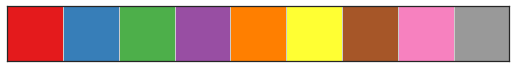

In [118]:
import seaborn as sns
sns.set()
sns.set_style('white')
#sns.set_style('whitegrid')
import matplotlib
plt.rcParams["axes.grid"] = True
plt.rc('font', family='serif')
#plt.rc('font', weight='bold')

current_palette = sns.color_palette(sns.hls_palette(5+1, l=.6, s=1.0))
#current_palette = sns.color_palette('tab20')
current_palette = sns.color_palette('Set1')
#current_palette = sns.color_palette('bright')
#current_palette = sns.color_palette('tab10')
#current_palette = sns.color_palette('tab20')

sns.palplot(current_palette)
current_palette = np.asarray(current_palette)


In [119]:

#pstd_xt
import matplotlib.pyplot as plt

#figsiz_=(15,1.8*3)
figsiz_=(6*3,2.25)
color_list = ['r','b','g'] 
predicted_model_list = ['gpind','gpdep','baselatent']

delta = 0.2
y_ = 5
xlim_=[0-delta,6+delta]
ylim_=[-y_-delta,y_+delta]
alpha_=0.25

train_range=[0,3]

In [120]:
#ncontext='05'
ncontext='10'
#ncontext='15'

#ncontext='20'
#ncontext='30'


In [121]:
xc,yc,xt,yt,xf,yf = train_set[chosen_idx]
xc.shape,yc.shape

(torch.Size([16, 10, 3]), torch.Size([16, 10, 3]))

In [122]:
saved_modelparam_path_list

['./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth',
 './bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth']

In [123]:
#if 

savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10


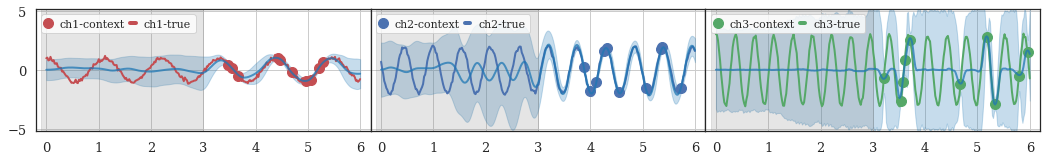

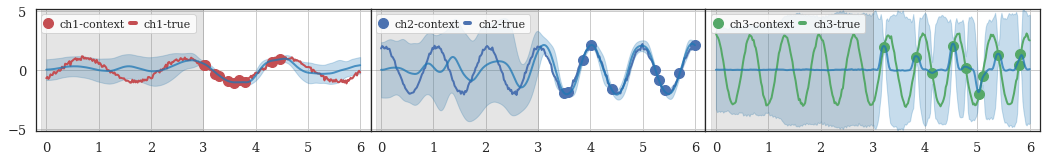





savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10


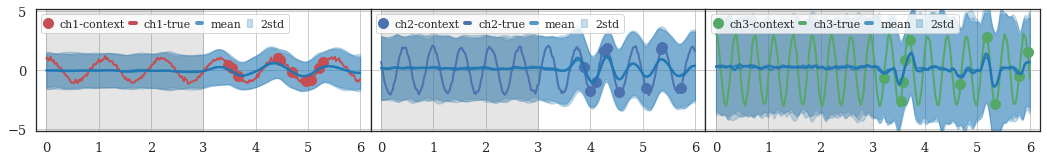

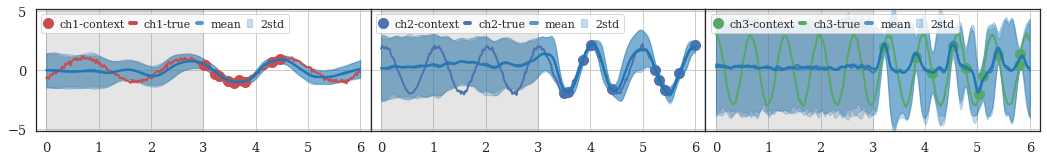





spikeslab version 7 with tempering 0.1
savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10
tensor([[[2.1615e-01, 7.6940e-01, 5.5033e-07, 3.9980e-11, 1.4444e-02],
         [1.1749e-21, 2.6022e-14, 1.0000e+00, 7.4057e-15, 1.2796e-17],
         [1.4139e-27, 7.2176e-22, 5.8726e-11, 1.0000e+00, 1.3209e-13]]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


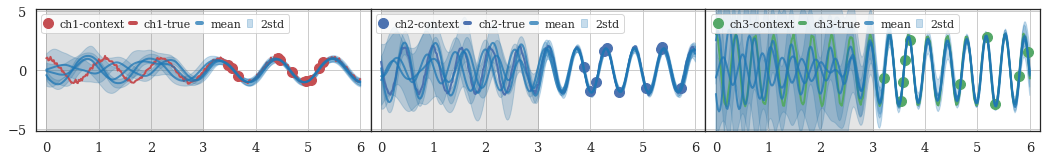

tensor([[[5.8663e-01, 4.0203e-01, 1.3952e-08, 1.6924e-13, 1.1332e-02],
         [2.8617e-07, 1.0000e+00, 1.5935e-07, 2.6877e-14, 2.5213e-15],
         [3.3674e-12, 2.3656e-07, 1.0000e+00, 1.5407e-15, 2.5995e-11]]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


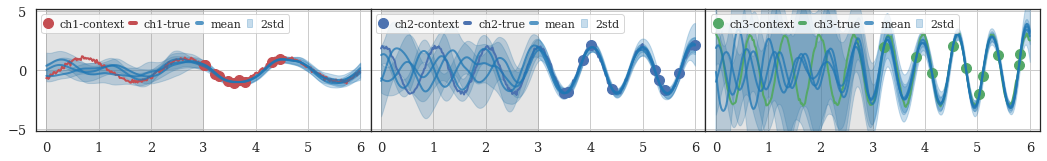





savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10


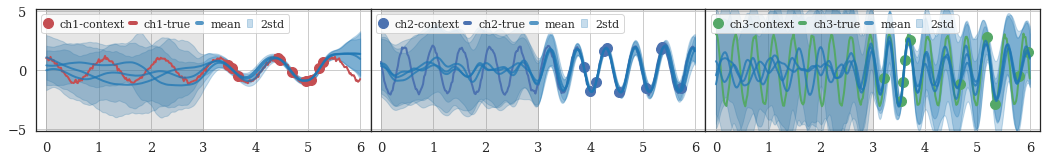

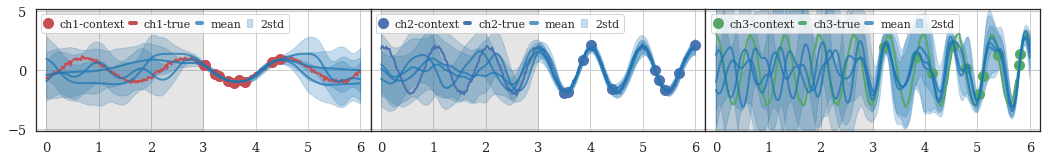





savepatt_set: ./syndata_sin3varying_varyingnct/depTrue_extra_ncontext10


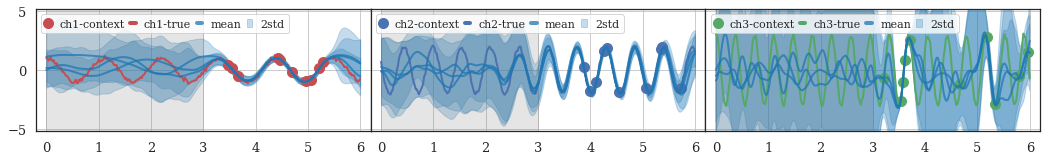

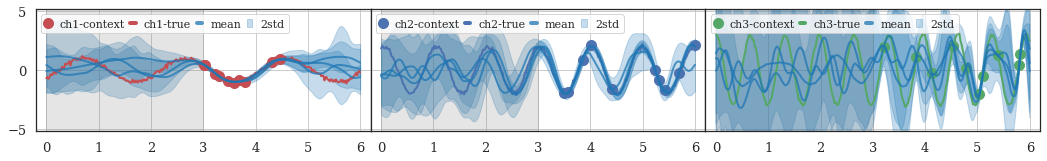

In [127]:

import os

chosen_idx=12
idx = 6   #chosen for fig
#idx = 8


model_list = []
weight_list = []
for saved_modelparam_path in saved_modelparam_path_list:

    #_,_,param_saved,param_detail = saved_modelparam_path.split('/')
    _,_,param_saved,param_detail = saved_modelparam_path.split('/')
    
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]    
    dep=True if deptype == 'depTrue' else False

    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    #datav = int(param_detail.split('_')[7][-5])
    #datav=4

    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(saved_modelparam_path)
    model.load_state_dict(saved_dict['state_dict'])
    tmp_numsamples = 3
    model.num_samples = tmp_numsamples
    
    model_list.append(model)



    dep=True if deptype == 'depTrue' else False
    #save_path_set = './regression_task/syndata_{}_v{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype,datav, dep, testtype, ncontext)
    #save_path_set = './syndata_{}_v{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype,datav, dep, testtype, ncontext)
    save_path_set = './syndata_{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype, dep, testtype, ncontext)
    
    print('savepatt_set: {}'.format(save_path_set))
    #save_path_set = './syndata_{}_v{}_varyingnct/dep{}_{}_ncontext{}_v2'.format(tasktype,datav, dep, testtype, ncontext)

    
    
    
    loaded = torch.load(save_path_set + '.db')
    #train_set = loaded['train_set']
    train_set = loaded['valid_set']
        
    #-----------------------------------
    #predict
    #-----------------------------------
    #for chosen_idx in [0,4,8,12]:    
    #for chosen_idx in [4,16]:    
    for chosen_idx in [2,16]:    
        
    #for chosen_idx in [0,12]:    
    #for chosen_idx in [0,8]:    
    
        
        xc,yc,xt,yt,xf,yf = train_set[chosen_idx]
        xc_ = xc[idx][...,None,:].unsqueeze(dim=0)
        yc_ = yc[idx].unsqueeze(dim=0)
        #yc_ = 0.*yc[idx].unsqueeze(dim=0)        # counter example, memorization does nor happen in our model
        xt_ = xt[idx][...,None,:].unsqueeze(dim=0)
        yt_ = yt[idx].unsqueeze(dim=0)
        xf_ = xf[idx][...,None,:].unsqueeze(dim=0)
        yf_ = yf[idx].unsqueeze(dim=0)

        xstar,ystar = xf_,yf_     
        #xstar,ystar = xt_,yt_     


        model.eval()
        if model.modelname in proposed_model_list:
            
            
            outs = model(xc_.cuda(),yc_.cuda(),xstar.cuda())       
        else:
            outs = model(xc_[:,:,0,:].cuda(),yc_.cuda(),xstar[:,:,0,:].cuda())       
        pmu_xt,pstd_xt = outs.pymu,outs.pystd

        if (hasattr(model,'gpsampler'))  and (hasattr(model.gpsampler,'neural_loglogits')):
            #print(model.gpsampler.logmu.exp())
            #print(1/model.gpsampler.logstd.exp())            
            print(F.softmax(model.gpsampler.neural_loglogits,dim=-1))
            weight_list.append(F.softmax(model.gpsampler.neural_loglogits,dim=-1).cpu().data.numpy().round(3))
            
            
            
            
        
        _, axs = plt.subplots(1, 3,figsize=figsiz_ , sharey=True)            
        plt.subplots_adjust( wspace=0.0, hspace=0.0)                
        color_list = ['r','b','g']
        if model.modelname in predicted_model_list:
            #fig=plt.figure(figsize=figsiz_)
            for i in range(nchannels):
                axs[i].axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.2)    #,label = 'train range'        
                axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10,label='ch{}-context'.format(i+1),alpha=1.0)    
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),ystar[0,:,i].cpu().data.numpy(),color_list[i],markersize=5,label = 'ch{}-true'.format(i+1),linewidth=2.0)                
                #axs[i].axvspan(xmin = train_range[0],xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.25,label = 'train range')
                
                for j in range(model.num_samples):
                    if j ==0:
                        axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),
                                    pmu_xt[j,0,:,i].cpu().data.numpy(),
                                    color='tab:blue',
                                    linewidth=2.,
                                    alpha=3*alpha_,
                                    label='mean') #,label = 'Model'

                        axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                         (pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         (pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         color='tab:blue', alpha=alpha_,
                                         label='2std')                
                        
                    else:
                        axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),
                                    pmu_xt[j,0,:,i].cpu().data.numpy(),
                                    color='tab:blue',
                                    linewidth=2.,
                                    alpha=3*alpha_) #,label = 'Model'

                        axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                         (pmu_xt+2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         (pmu_xt-2*pstd_xt)[j,0,:,i].cpu().data.numpy(),
                                         color='tab:blue', alpha=alpha_)                                    
                        
                    
                    
                    axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
                    axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
                    axs[i].set_xlim(xlim_)
                    axs[i].set_ylim(ylim_)
                    leg=axs[i].legend(loc='upper left',fontsize=11,ncol=5,columnspacing=0.5,handlelength=0.5,handletextpad=.75)    
                    for line in leg.get_lines():
                        line.set_linewidth(4) 
                        line.set_markersize(4)     
                                        
                        
                        

        else:

            for i in range(nchannels):
                axs[i].axvspan(xmin = train_range[0]-0.1,xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.2) #,label = 'train range'
                axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10,label='ch{}-context'.format(i+1),alpha=1.0)    
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),ystar[0,:,i].cpu().data.numpy(),color_list[i],markersize=5,label = 'ch{}-true'.format(i+1),linewidth=2.0)                
                axs[i].plot(xstar[0,:,0,i].cpu().data.numpy(),
                            pmu_xt[0,:,i].cpu().data.numpy(),
                            color='tab:blue',
                            linewidth=2.,
                            alpha=3*alpha_)   #,label = 'Model'         
                
                axs[i].fill_between(xstar[0,:,0,i].cpu().data.numpy(),
                                 (pmu_xt+2*pstd_xt)[0,:,i].cpu().data.numpy(),
                                 (pmu_xt-2*pstd_xt)[0,:,i].cpu().data.numpy(),
                                 color='tab:blue', alpha=alpha_)                

                
                axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
                axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
                axs[i].set_xlim(xlim_)
                axs[i].set_ylim(ylim_)
                
                

                leg=axs[i].legend(loc='upper left',fontsize=11,ncol=5,columnspacing=0.5,handlelength=0.5,handletextpad=.75)    
                for line in leg.get_lines():
                    line.set_linewidth(4) 
                    line.set_markersize(4)     

                
                        
        
        #savefig_dir = './fig_{}_dep{}/'.format(datatype,dep)
        #if not os.path.isdir(savefig_dir):
        #    os.makedirs(savefig_dir)    
        
        #savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_ncontext{}_idx{}_together'.format(datav,str(dep).lower(), modelname ,ncontext,chosen_idx) 
        #print('savefigname: {}'.format(savefigname))
        #plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
        plt.show()
    
    print('\n'*3)


In [128]:
#post_samples.shape

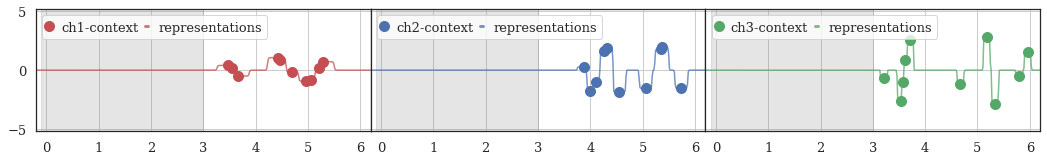

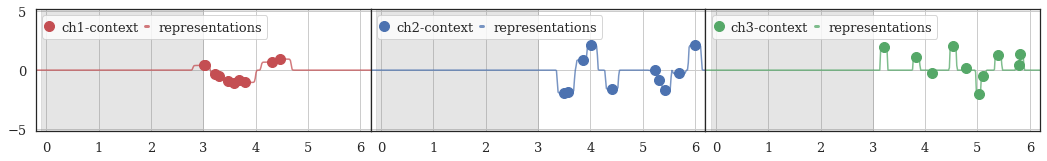

./bestparams/bestparam_sin3varying/depTrue_extra_base_initl0.1_deep_nsamples1_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






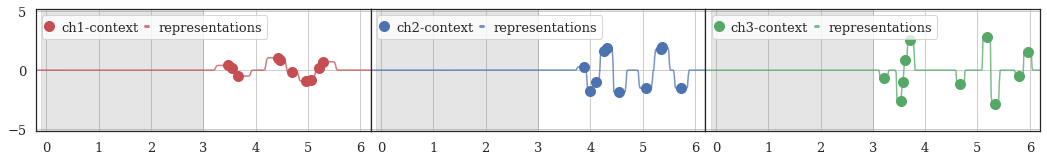

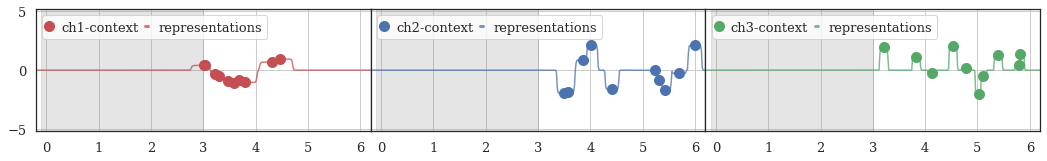

./bestparams/bestparam_sin3varying/depTrue_extra_baselatent_initl0.1_deep_nsamples10_nepochs500_datav11_gppriorscale0.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])




spikeslab version 7 with tempering 0.1


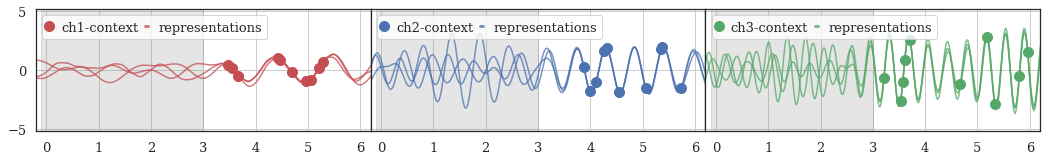

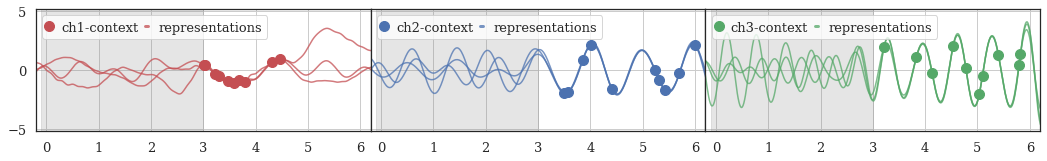

./bestparams/bestparam_sin3varying/depTrue_extra_gpdep_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






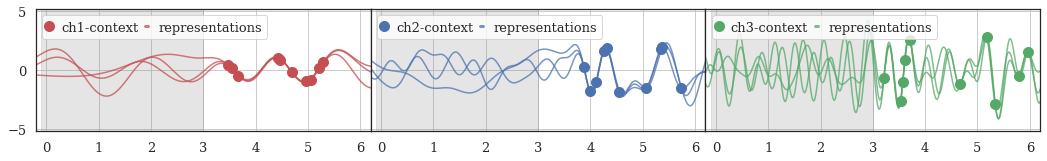

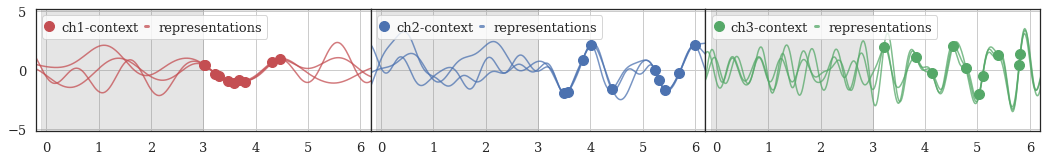

./bestparams/bestparam_sin3varying/depTrue_extra_gpind_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv60_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






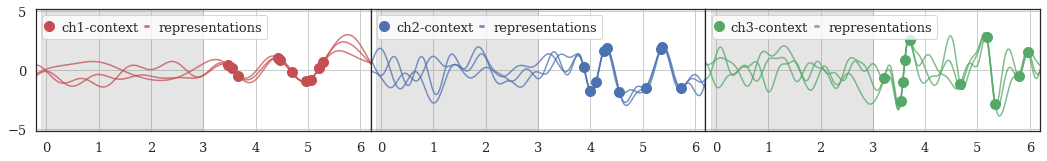

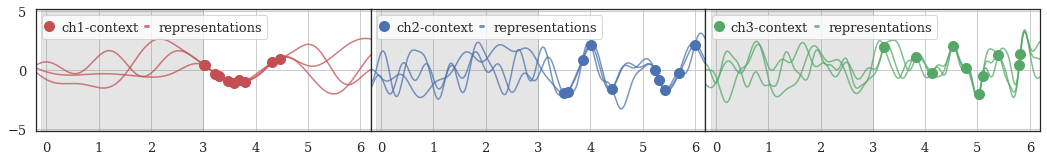

./bestparams/bestparam_sin3varying/depTrue_extra_gpindrbf_initl1.0_deep_nsamples10_nepochs500_datav11_gppriorscale1.0_runv61_reglam0.0.pth
xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape
torch.Size([1, 10, 1, 3]) torch.Size([1, 10, 3]) torch.Size([1, 50, 1, 3]) torch.Size([1, 50, 3]) torch.Size([1, 300, 1, 3]) torch.Size([1, 300, 3])






In [130]:

for saved_modelparam_path in saved_modelparam_path_list:

    _,_,param_saved,param_detail = saved_modelparam_path.split('/')
    tasktype = param_saved.split('_')[1]
    deptype = param_detail.split('_')[0]    
    dep=True if deptype == 'depTrue' else False

    deptype = param_detail.split('_')[0]
    modelname = param_detail.split('_')[2]
    cnntype = param_detail.split('_')[4]
    #datav = int(param_detail.split('_')[7][-5])
    #datav=4

    model,opt,lossfun =  get_model(modelname=modelname,cnntype=cnntype)
    saved_dict = torch.load(saved_modelparam_path)
    model.load_state_dict(saved_dict['state_dict'])    
    #tmp_numsamples = 3
    model.num_samples = tmp_numsamples



    dep=True if deptype == 'depTrue' else False
    save_path_set = './syndata_{}_varyingnct/dep{}_{}_ncontext{}'.format(tasktype, dep, testtype, ncontext)

        #'./syndata_mosm_v6/depFalse_extra_ncontext50.db'
    

    
    loaded = torch.load(save_path_set + '.db')
    #train_set = loaded['train_set']
    train_set = loaded['valid_set']
        
    #-----------------------------------
    #predict
    #-----------------------------------
    #for chosen_idx in [0,4,8,12]:    
    #for chosen_idx in [4,16]:    
    for chosen_idx in [2,16]:    
        
        
        
    #for chosen_idx in [0,12]:            
        xc,yc,xt,yt,xf,yf = train_set[chosen_idx]
        xc_ = xc[idx][...,None,:].unsqueeze(dim=0)
        yc_ = yc[idx].unsqueeze(dim=0)
        xt_ = xt[idx][...,None,:].unsqueeze(dim=0)
        yt_ = yt[idx].unsqueeze(dim=0)
        xf_ = xf[idx][...,None,:].unsqueeze(dim=0)
        yf_ = yf[idx].unsqueeze(dim=0)

        xstar,ystar = xf_,yf_     
        #xstar,ystar = xt_,yt_     

        if model.modelname in proposed_model_list:
            post_samples,xa = model.sample_functionalfeature(xc_.cuda(),yc_.cuda(),xstar.cuda(),numsamples=tmp_numsamples)
            model.num_samples = tmp_numsamples 

        else:
            post_samples,xa = model.sample_functionalfeature(xc_[:,:,0,:].cuda(),yc_.squeeze().cuda(),xstar[:,:,0,:].cuda(),numsamples=1)
            post_samples = post_samples[:,None,:,:]


        
        
        color_list = ['r','b','g']
        
        _ , axs = plt.subplots(1, 3,figsize=figsiz_ , sharey=True)            
        plt.subplots_adjust( wspace=0.0, hspace=0.0)
                
        for i in range(nchannels):
            axs[i].axvspan(xmin = train_range[0]-0.1,xmax = train_range[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.2)    #,label = 'train range'        
            axs[i].plot(xc_[0,:,0,i].cpu().data.numpy(),yc_[0,:,i].cpu().data.numpy(),color_list[i]+'o',markersize=10,label='ch{}-context'.format(i+1),alpha=1.0)    

            for j in range(post_samples.size(1)):
                #plt.plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i]+'-s',markersize=2)        
                if j==0:
                    axs[i].plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i],alpha=0.75,linewidth=1.5,label='representations')            
                else:
                    axs[i].plot(xa[0,:,0].cpu().data.numpy(),post_samples[0,j,:,i].cpu().data.numpy(),color_list[i],alpha=0.75,linewidth=1.5)        
    
            axs[i].xaxis.set_tick_params(labelsize=fontsiz_)
            axs[i].yaxis.set_tick_params(labelsize=fontsiz_)                    
            axs[i].set_xlim(xlim_)
            axs[i].set_ylim(ylim_)

            leg=axs[i].legend(loc='upper left',fontsize=fontsiz_,ncol=4,labelspacing=1.0,handlelength=0.25,columnspacing=0.5)
            for line in leg.get_lines():
                line.set_linewidth(3) 
                line.set_markersize(3)               
                
                
#         savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_ncontext{}_idx{}_representaion'.format(datav,str(dep).lower(), modelname ,ncontext,chosen_idx)         
#         print('savefigname: {}'.format(savefigname))
#         plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
        plt.show()
                

            
    print(saved_modelparam_path)
    print('xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape')
    print(xc_.shape,yc_.shape,xt_.shape,yt_.shape,xstar.shape,ystar.shape)
    print('\n'*3)

    
    

In [131]:
# import numpy as np
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9.75, 3))
# for ax in axes.flat:
#     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)

# fig.colorbar(im, ax=axes.ravel().tolist())

# plt.show()

In [132]:
#model.gpsampler.logmu.exp()
#model

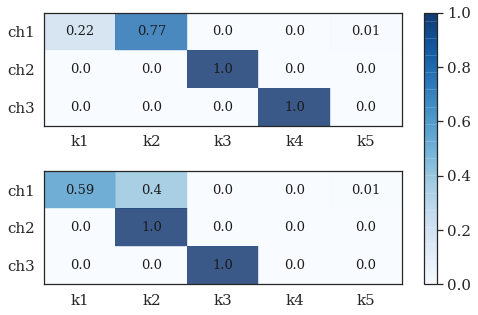

In [142]:
from matplotlib.ticker import FuncFormatter

ynames_list = ['ch1','ch2','ch3']
xnames_list = ['k1','k2','k3','k4','k5']
#figsiz_=(3,2.7)
figsiz_=(8,5)
fontsiz_=15.0
modelname='gpdep'


fig, axes = plt.subplots(2, 1,figsize=figsiz_ , sharey=True)      
plt.subplots_adjust( wspace=0.0, hspace=0.4)     
plt.gca().invert_yaxis()

for k,ax in enumerate(axes.flat):
    im = ax.pcolormesh(weight_list[k][0,:], cmap='Blues', vmin=0, vmax=1.0,alpha=0.8)

    ax.set_xticks(np.arange(len(xnames_list))+0.5)
    ax.set_xticklabels(xnames_list,fontsize=fontsiz_)
    
    ax.set_yticks(np.arange(len(ynames_list))+0.5)
    ax.set_yticklabels(ynames_list,fontsize=fontsiz_)
    
    for i in range(len(ynames_list)):
        for j in range(len(xnames_list)):
            text = ax.text(j+0.5, i+0.5, weight_list[k][0,i,j].round(2),
                           ha="center", va="center", color="k",fontsize=fontsiz_-2)    
    
ticks = [0.0,0.2,0.4,0.6,0.8,1.0]
cbar=fig.colorbar(im, ax=axes.flat,ticks=ticks)

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(fontsiz_)

# savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_weight'.format(datav,str(dep).lower(), modelname )  
# print('savefigname: {}'.format(savefigname))
# plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

## spectral density

In [138]:
tmp_model = model_list[2]
mu,inv_std = tmp_model.gpsampler.logmu.exp(),1/(tmp_model.gpsampler.logstd.exp()+1e-4)
mu,inv_std

(tensor([[6.9631e-04],
         [1.0658e+00],
         [1.8096e+00],
         [2.7823e+00],
         [4.3055e+00]], device='cuda:0', grad_fn=<ExpBackward0>),
 tensor([[0.3634],
         [0.2000],
         [0.2003],
         [0.2171],
         [0.9896]], device='cuda:0', grad_fn=<MulBackward0>))

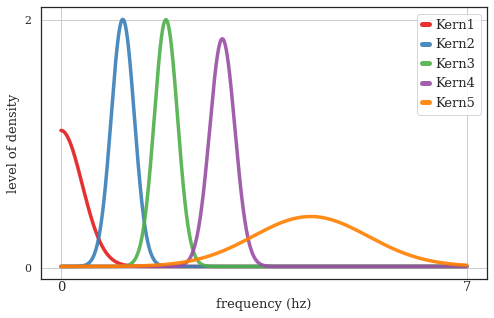

In [143]:
modelname  = 'gpdep'

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.

x_axis = np.arange(0, 7, 0.001)
#figsiz__=(3,2.7)
figsiz__=(8,5)

fig, ax = plt.subplots(figsize=figsiz__)
ax.tick_params(axis="x",direction="in", pad=2)

for i,(imu,istd) in enumerate(zip(mu,inv_std)):
    plt.plot(x_axis, .01+norm.pdf(x_axis,imu.cpu().data.numpy(),1*istd.cpu().data.numpy()),
             linewidth=3.5,
             alpha=0.9,
             color=current_palette[i],
             label = 'Kern{}'.format(i+1))



    
plt.yticks([0,2])
plt.xticks([0,7])

plt.xlabel('frequency (hz)',fontsize=13)
plt.ylabel('level of density',fontsize=13)
plt.xticks(fontsize=13)
leg=plt.legend(loc='upper right',fontsize=13,ncol=1,columnspacing=0.5,handlelength=0.5,handletextpad=.5)

for line in leg.get_lines():
    line.set_linewidth(5) 
    line.set_markersize(5)     

# savefigname = savefig_dir + datatype  + '_datav{}_dep{}_{}_density_withleg'.format(datav,str(dep).lower(), modelname )  
# print('savefigname: {}'.format(savefigname))
# plt.savefig(savefigname  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')

plt.show()